In [123]:
import io
import os
import re
import sys
import csv
import gzip
import time
import json
import pickle
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
from scipy.stats import pearsonr
# import sqlite3
# from PIL import Image
import matplotlib.pyplot as plt
# from plotnine import *
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
# from collections import Counter
# import seaborn as sns
# import matplotlib.colors as mcolors
# from matplotlib.ticker import FuncFormatter
import itertools
import collections
import pyreadr
import psa
# import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None

# Genuine logics changed from the main script were marked by string **X** in the original R files.
# Simplicity changes were marked by string **Y**

* Further optimisable: 
    - Maybe don't trim pre-CDS region?
    - While imputation HLA alleles from database, try using needle aligner?

In [244]:
gene = 'DRB1'
nucleotides = ['A', 'T', 'C', 'G']
ipd_gen_file = '/Users/sus_zhang/Desktop/Suuuuuuuus/misc_data/alignments/' + gene + '_gen.txt'
if not os.path.exists(ipd_gen_file):
#     ipd_gen_file = '/well/band/users/rbx225/recyclable_files/hla/alignments/' + gene + '_gen.txt'
    ipd_gen_file = '/well/band/users/rbx225/recyclable_files/hla_reference_files/alignments/' + gene + '_gen.txt'

hla_gene_information = pd.read_csv('/well/band/users/rbx225/software/QUILT_sus/hla_ancillary_files/hla_gene_information.tsv', sep = ' ')
strand = hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['Strand'].iloc[0]

original_refdir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/QUILT_ref_files/'
auxiliary_dir = '/well/band/users/rbx225/GAMCC/results/hla/imputation/ref_panel/auxiliary_files/' 
gamcc_dir = '/well/band/users/rbx225/GAMCC/'

ref_samples = pd.read_csv(auxiliary_dir + 'oneKG.samples', sep = ' ')
hlatypes = pd.read_csv(auxiliary_dir + '20181129_HLA_types_full_1000_Genomes_Project_panel.txt', sep = '\t')
# gamcc_hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv', unique_two_field = False)
# gamcc_hla = gamcc_hla[gamcc_hla['Locus'] == gene]
# gamcc_hla = gamcc_hla[['SampleID', 'Two field1', 'Two field2']].reset_index(drop = True)
# gamcc_hla.columns = ['Sample ID', 'HLA-DRB1 1', 'HLA-DRB1 2']
# hlatypes = gamcc_hla

phased_vcf = "/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/oneKG.chr6.vcf.gz"
# phased_vcf = "/well/band/users/rbx225/GAMCC/results/two-stage-imputation/vanilla/malariaGen_v1_b38_topmed/vcf/chr6.dose.vcf.gz"

ref_samples_removed = ref_samples[~ref_samples['SAMPLE'].isin(hlatypes['Sample ID'].tolist())]
samples_to_remove = ref_samples_removed['SAMPLE'].tolist()
reference_exclude_samplelist_file = ''
if reference_exclude_samplelist_file != '':
    samples_to_remove = samples_to_remove + lcwgsus.read_tsv_as_lst(reference_exclude_samplelist_file)
# if samples_to_remove is not none, save to "hlauntyped.exclude.txt"

hlatypes = hlatypes[~hlatypes['Sample ID'].isin(samples_to_remove)].sort_values(by = 'Sample ID').reset_index(drop = True)

In [165]:
def extract_snps_from_row(refrow, altrow, allele_pos):
    # This is still not perfect for indel detections, but we're gonna remove suspicious variants anyway so dont really care.
    # Try cope with insertions maybe
    allele_pos = np.array(allele_pos)
    refrow = refrow.to_numpy()
    altrow = altrow.to_numpy()

    variant_pos = np.unique(allele_pos[altrow != refrow])                
    vcf = pd.DataFrame(columns = ['pos', 'ref', 'alt'])
    
    if len(variant_pos) != 0:
        for i in variant_pos:
            ref_variant = ''.join(refrow[allele_pos == i])
            alt_variant = ''.join(altrow[allele_pos == i])
            if ref_variant != alt_variant and not re.search(r"\*", alt_variant):
                vcf.loc[len(vcf)] = [i, ref_variant, alt_variant]

        j = 0
        vcf2 = pd.DataFrame(columns = ['pos', 'ref', 'alt'])
        alt_arrays = vcf['alt'].str.replace('.', '').to_numpy()
        ref_arrays = vcf['ref'].str.replace('.', '').to_numpy()
        remove_rows = np.zeros(vcf.shape[0], dtype=int)

        while j < vcf.shape[0]:
            if alt_arrays[j] == "" and ref_arrays[j] != "": # Deletion from the perspective of altrow
                current_pos = vcf.iloc[j, 0]
                all1 = vcf.iloc[j, 1]
                all2 = vcf.iloc[j, 2]
                remove_rows[j] = 1
                j += 1
                while j < vcf.shape[0] and alt_arrays[j] == "":
                    all1 += vcf.iloc[j, 1]
                    all2 += vcf.iloc[j, 2]
                    remove_rows[j] = 1
                    j += 1
                vcf2.loc[len(vcf2)] = [current_pos, all1, all2]
            j += 1

        vcf = pd.concat([vcf[remove_rows == 0], vcf2])

        if vcf.shape[0] > 0:
            vcf['ref'] = vcf['ref'].str.replace('.', '').to_numpy()
            vcf['alt'] = vcf['alt'].str.replace('.', '').to_numpy()
            vcf = vcf[vcf['ref'] != vcf['alt']].sort_values(by = 'pos')
    return vcf

In [234]:
with open(ipd_gen_file, "r") as file:
    lines = file.readlines()
gDNA_idx = []
names = []
i = 0
while len(gDNA_idx) < 2:
    l = lines[i]
    if 'gDNA' in l:
        gDNA_idx.append(i)
    elif l.lstrip(' ').split(' ')[0].startswith(gene + '*'):
        name = l.lstrip(' ').split(' ')[0]
        names.append(name)
    i += 1
    
first_base = int(lines[gDNA_idx[0]].split(' ')[-1].split('\n')[0])
n_alleles = gDNA_idx[1] - gDNA_idx[0] - 3

alleles_dict = {k:'' for k in names}
for i, s in enumerate(lines):
    r = s.lstrip(' ')
    if r.startswith(gene):
        r = r.rstrip(' \n')
        name = r.split(' ')[0]
        sequence = r.split(' ')[1:]
        sequence = ''.join(sequence)
        alleles_dict[name] = alleles_dict[name] + sequence

db = pd.DataFrame({key: list(value) for key, value in alleles_dict.items()}).T
db = db.drop(columns=db.columns[db.eq('|').all()])
db.columns = range(db.shape[1])

length = len(db.columns)
positions = [first_base]*length

db.loc[len(db)] = positions

r_idx = len(db) - 1
for i in db.columns[1:]:
    if db.iloc[0, i] == '.':
        db.iloc[r_idx, i] = db.iloc[r_idx, i-1]
    else:
        if db.iloc[r_idx, i-1] != -1:
            db.iloc[r_idx, i] = db.iloc[r_idx, i-1] + 1
        else:
            db.iloc[r_idx, i] = db.iloc[r_idx, i-1] + 2 # No zero in position. ATG is encoded by 1.
db.columns = db.iloc[r_idx]
db = db.iloc[:r_idx]

db = db.loc[:,db.columns >= 0] # Trims genomes before CDS, is this really necessary?
db = db.apply(lambda c: c.replace('-', c[0]) ,axis = 0)

if strand != 1:
    db.replace({'A': 't', 'C': 'g', 'G': 'c', 'T': 'a'}, inplace=True)
    db.replace({'a': 'A', 'c': 'C', 'g': 'G', 't': 'T'}, inplace=True)
    db = db.iloc[:, ::-1]
db.columns = range(db.shape[1])
    
reference_allele = 'DRB1*15:01:01:01' # We can store this somewhere if we are using that same fasta. Otherwise has to take the fasta and determine
counts = db.loc[reference_allele,:].value_counts()
aligned_bases = counts[counts.index.isin(nucleotides)].sum()

if strand == 1:
    genome_pos =  hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['Start'].iloc[0]
    start = genome_pos
else:
    genome_pos =  hla_gene_information[hla_gene_information['Name'] == ('HLA-' + gene)]['End'].iloc[0]
    start = genome_pos - aligned_bases + 1
end = start + aligned_bases - 1

allele_pos = [start]*db.shape[1]
for i, n in enumerate(db.loc[reference_allele,:].values[1:], start = 1):
    if n in nucleotides:
        allele_pos[i] = allele_pos[i - 1] + 1
    else:
        allele_pos[i] = allele_pos[i - 1]

# ourpos -> allele_pos
# first_row = ourrow is the index in db of the referece allele

variants_df = []
for i in range(len(db)):
    variants_df.append(extract_snps_from_row(db.loc[reference_allele,:], db.iloc[i,], allele_pos))
vcf = pd.concat(variants_df).drop_duplicates()
vcf = vcf[(vcf['ref'].isin(nucleotides)) & (vcf['alt'].isin(nucleotides))].sort_values(by = 'pos').reset_index(drop = True)

In [235]:
allele_pos = np.array(allele_pos)
dbcopy = pd.DataFrame()
aligned_df = pd.DataFrame()
variants_to_remove = []

def recode_variant(value):
    if value == '*':
        return -1
    elif value == a2:
        return 1
    else:
        return 0

for i in range(vcf.shape[0]):
    pos, a1, a2 = vcf.iloc[i, :3]
    index = np.where((allele_pos == pos))[0]
    
    if len(index) == 1:
        index = index[0]
        dbcopy[dbcopy.shape[1]] = db[index]        
        aligned_df[aligned_df.shape[1]] = db[index].apply(recode_variant)
    else:
        variants_to_remove.append(i)

vcf = vcf[~vcf.index.isin(variants_to_remove)].reset_index(drop = True) 
# This is a remedy when extract_snps_from_row fails to detect insertions. 
# For DRB1 we get 2442 variants instead of 2452, fairly good I'd say
dbfull = db
db = dbcopy

In [236]:
sample = pd.DataFrame({
    "ID_1": aligned_df.index,
    "ID_2": aligned_df.index,
    "missing": 0
})
vcf['id'] = 'chr6:' + vcf['pos'].astype(str)
haps = aligned_df.T
cond = (haps == -1).mean(axis=1) < 0.1
haps = haps[cond].reset_index(drop = True)
vcf = vcf[cond].reset_index(drop = True)

start = vcf.loc[0, 'pos']
end =vcf.loc[len(vcf) - 1, 'pos']

cond = (allele_pos >= start) & (allele_pos <= end)
allele_pos = allele_pos[cond]
dbfull = dbfull.iloc[:, np.where(cond == True)[0]]
dbfull.columns = range(dbfull.shape[1])

In [237]:
# Imputing database alleles
for i, a in enumerate(haps.columns):
    haps_undetermined = haps[a] == -1
    # db_determined = dbfull.loc[a, :] != "*"

    allele_col = haps[~haps_undetermined][a]
    subseted_db =  haps[~haps_undetermined] 
    pairwise_distance = subseted_db.sub(subseted_db[a], axis=0)
    counts = pairwise_distance.abs().sum().sort_values().iloc[1:]
    closest_allele_idx = 0
    substituted_nucleotides = np.array([np.nan]*np.sum(haps_undetermined))
    substituted_indices = haps_undetermined[haps_undetermined == True].index

    while np.isnan(substituted_nucleotides).any() > 0:
        closest_allele = counts.index[closest_allele_idx]
        
        target_haplotype = haps.loc[substituted_indices, closest_allele]
        substitutable = target_haplotype[target_haplotype.values != -1]
        substituted_nucleotides[substitutable.index] = substitutable.values
        closest_allele_idx += 1

    haps.loc[substituted_indices, a] = substituted_nucleotides
    # haps has dim n_variants * n_alleles

In [238]:
# oldsnpinfo -> prepared_vcf
# ss -> variant_alleles
# samples -> alleles
# qq -> positions

prepared_vcf = vcf
alleles = db.index
prepared_vcf['pos']  = prepared_vcf['pos'].astype(int)

variant_alleles = haps

positions = vcf['pos'].astype(float).values
zz = np.zeros(haps.shape[0]) 
for i in range(len(zz)):
    zz[i] = np.sum(allele_pos == positions[i])
zz3 = np.zeros_like(zz)
for i in range(len(zz3)):
    zz3[i] = np.sum(positions == positions[i])
filter_conditions = (zz3 == 1) & (zz == 1)

# keep sites uniquely mapping, not overlapping another SNP, with at most 10% gaps and 2-fold more non-ancestral than gaps
snpinfo = prepared_vcf.loc[filter_conditions, :].reset_index(drop = True)
snpinfo = snpinfo.iloc[:,[3, 0, 1, 2]]
variant_alleles = variant_alleles.loc[filter_conditions, :]
haps = variant_alleles.copy().reset_index(drop = True)
# haps is `n_variant \times n_alleles` df, with each entry as 0/1 representing ref/alt from the fake vcf "prepared_vcf"

In [245]:
start = snpinfo['pos'].values[0]
end = snpinfo['pos'].values[-1]

typed_samples = hlatypes['Sample ID'].tolist()

subset_samples = None
# subset_samples = lcwgsus.read_tsv_as_lst('/well/band/users/rbx225/GAMCC/data/sample_tsvs/fv_gm_names.tsv')
# subset_samples = ','.join(subset_samples)

command = "bcftools view -r chr6:" + str(int(start)) + "-" + str(int(end)) + " " + phased_vcf
if subset_samples is not None:
    command = command + ' | bcftools view -s ' + subset_samples

# command = "bcftools view -r chr6:32579017-32589729 /well/band/users/rbx225/GAMCC/results/imputation/vcfs/oneKG/quilt.chr6.vcf.gz | bcftools filter -i 'INFO_SCORE > 0.5' | bcftools view -s " + subset_samples
    
snp_haps = subprocess.run(command, shell = True, capture_output = True, text = True).stdout[:-1].split('\n')
snp_haps = [i.split('\t') for i in snp_haps if '##' not in i]
snp_haps = pd.DataFrame(snp_haps)
snp_haps.columns = snp_haps.iloc[0]  # Set the first row as the header
snp_haps = snp_haps[1:].reset_index(drop = True)
## Remove this renaming bit later:
# sl = pd.read_csv(gamcc_dir + SAMPLE_LINKER_FILE)
# sl = {k:v for k, v in zip(sl['Sample_Name'], sl['Chip_Name'])}
# renamed_cols = snp_haps.columns[:9].tolist()
# for s in subset_samples.split(','):
#     renamed_cols.append(sl[s])
# snp_haps.columns = renamed_cols
# for c in snp_haps.columns[9:]: # So only retain GT field, assume it is always the first but later clean vcf first before putting in to phasing
#     snp_haps[c] = snp_haps[c].str.split(':').str.get(0) 
## End of removal

retained_samples = snp_haps.columns.intersection(typed_samples).tolist()
hlatypes = hlatypes[hlatypes['Sample ID'].isin(retained_samples)].reset_index(drop = True)

snp_haps = snp_haps.drop(columns = ['#CHROM', 'ID', 'QUAL', 'FILTER', 'INFO', 'FORMAT'])
snp_haps = snp_haps[(snp_haps['REF'].str.len() == 1) & (snp_haps['ALT'].str.len() == 1)]
snp_haps = snp_haps.rename(columns = {'POS': 'pos', 'REF': 'ref', 'ALT': 'alt'})
snp_haps['snp'] = (snp_haps['pos'].astype(str) + snp_haps['ref'] + snp_haps['alt']).values
snp_haps['pos'] = snp_haps['pos'].astype(int)
snp_haps = snp_haps[['snp', 'pos', 'ref', 'alt'] + retained_samples]
hrcfirstalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
hrcsecondalleles = snp_haps[['snp', 'pos', 'ref', 'alt']]
for s in retained_samples:
    hrcfirstalleles[s] = snp_haps[s].str.split('|').str.get(0).astype(int)
    hrcsecondalleles[s] = snp_haps[s].str.split('|').str.get(1).astype(int)

original_variants = (snpinfo['pos'].astype(str) + snpinfo['ref'] + snpinfo['alt']).values
flipped_variants = (snpinfo['pos'].astype(str) + snpinfo['alt'] + snpinfo['ref']).values

def subset_snp_haps(hrcfirstalleles, original_variants = original_variants, flipped_variants = flipped_variants):    
    hrcfirstalleles_original = hrcfirstalleles[hrcfirstalleles['snp'].isin(original_variants)]
    hrcfirstalleles_flipped = hrcfirstalleles[hrcfirstalleles['snp'].isin(flipped_variants)]
    if len(hrcfirstalleles_flipped) == 0:
        hrcfirstalleles = hrcfirstalleles_original.drop(columns = ['snp', 'pos', 'ref', 'alt']).reset_index(drop = True)
    elif len(hrcfirstalleles_flipped) == 1:
        hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
        hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped.to_frame().T], axis = 0).sort_index()
    else:
        hrcfirstalleles_flipped.loc[:, retained_samples] = 1 - hrcfirstalleles_flipped.loc[:, retained_samples]
        hrcfirstalleles = pd.concat([hrcfirstalleles_original, hrcfirstalleles_flipped]).sort_index()
    hrcfirstalleles = hrcfirstalleles.sort_index().reset_index(drop = True)
    hrcfirstalleles.columns = range(hrcfirstalleles.shape[1])
    return hrcfirstalleles.T

hrcfirstalleles = subset_snp_haps(hrcfirstalleles)
hrcsecondalleles = subset_snp_haps(hrcsecondalleles)

In [247]:
samples = np.array(alleles).reshape(-1, 1)
c1 = [s[0].split('*') for s in samples]
vv = np.empty((samples.shape[0], 3), dtype=object)
ww = [c[1] for c in c1]
for i in range(len(c1)):
    vv[i, 0] = c1[i][0]
c1 = [w.split(':') for w in ww]
for i in range(len(c1)):
    vv[i, 1] = c1[i][0]
    vv[i, 2] = c1[i][1]
fourdigit = [f"{vv[i, 1]}:{vv[i, 2]}" for i in range(len(vv))]
ufourdigit = np.unique(fourdigit)
# Convert reference alleles to 4-digit resolution. vv and ww are just intermediate variables of no use
# ufourdigit is unique 4-digit alleles

haps = np.array(haps, dtype=float)
newhaps = np.empty((haps.shape[0], len(ufourdigit)))
for i in range(newhaps.shape[1]):
    tt = np.where(np.array(fourdigit) == ufourdigit[i])[0]
    if len(tt) < 2:
        tt = np.concatenate((tt, tt))
    newhaps[:, i] = np.mean(haps[:, tt], axis=1)
newhaps = pd.DataFrame(newhaps, columns = ufourdigit)

cols = snpinfo.columns.tolist()
full_vcf = snp_haps.copy()[cols[1:]]
same = pd.merge(full_vcf, snpinfo, on = cols[1:], how = 'inner')
newhaps_original = newhaps.loc[snpinfo[snpinfo['id'].isin(same['id'].values)].index,:]

snpinfo_flipped = snpinfo.iloc[:,[0, 1, 3, 2]]
snpinfo_flipped.columns = cols
flipped = pd.merge(full_vcf, snpinfo_flipped, on = cols[1:], how = 'inner')
newhaps_flipped = 1 - newhaps.loc[snpinfo_flipped[snpinfo_flipped['id'].isin(flipped['id'].values)].index,:]

if len(newhaps_flipped) == 0:
    newhaps = newhaps_original
elif len(newhaps_flipped) == 1:
    newhaps = pd.concat([newhaps_original, newhaps_flipped.to_frame().T], axis = 0).sort_index()
else:
    newhaps = pd.concat([newhaps_original, newhaps_flipped]).sort_index()
newhaps2 = newhaps.reset_index(drop = True)

In [248]:
region_pattern = f"HLA.{gene}."
cols = [i for i, col in enumerate(hlatypes.columns) if re.search(region_pattern, col)]

reftypes1 = hlatypes.iloc[:, cols[0]].astype(str).tolist()
reftypes1 = [re.sub(r"\*", "", t) for t in reftypes1]
reftypes1 = np.array(reftypes1)
reftypes2 = hlatypes.iloc[:, cols[1]].astype(str).tolist()
reftypes2 = [re.sub(r"\*", "", t) for t in reftypes2]
reftypes2 = np.array(reftypes2)

In [249]:
def phase_subtraction(array1, array2, indices):
    array1 = array1.iloc[:,indices].values
    array2 = array2[:, indices]
    result = np.array([np.nan]*array1.shape[0])
    for i in range(array1.shape[0]):
        if np.any(np.isnan(array1[i,:])) or np.any(np.isnan(array2[i,:])):
            tmp = np.nan
        else:
            tmp = np.sum(np.abs(array1[i,:] - array2[i,:]))
        result[i] = tmp
    return result

In [266]:
def get_pred_alleles(reftype, newhaps2 = newhaps2):
    predalleles = np.array(pd.DataFrame(np.nan, index=range(len(reftype)), columns=range(newhaps2.shape[0])))
    for i, a in enumerate(reftype):
        if (a == '-9') or (a == 'nan'):
            pass
        elif '/' not in a:
            if a in newhaps2.columns:
                predalleles[i, :] = newhaps2.loc[:, a].T
            else:
                pass
        else:
            valid_alleles = []
            for j in a.split('/'):
                if ':' not in j:
                    onefield = a.split('/')[0].split(':')[0]
                    j = onefield + ':' + j
                if j in newhaps2.columns:
                    valid_alleles.append(j)
            if len(valid_alleles) == 0:
                pass
            else:
                predalleles[i, :] = newhaps2.loc[:, valid_alleles].mean(axis = 1).values
    return predalleles

predfirstalleles = get_pred_alleles(reftypes1)
predsecondalleles = get_pred_alleles(reftypes2)

In [270]:
obsgen = hrcfirstalleles + hrcsecondalleles
predgen = pd.DataFrame(predfirstalleles + predsecondalleles)
corr = np.empty(obsgen.shape[1])
for i in range(obsgen.shape[1]):
    with np.errstate(invalid='ignore'):
        corr[i] = obsgen.loc[:, i].corr(predgen.loc[:, i])

valid_corr_indices = np.where((corr > 0.8) & (~np.isnan(corr)))[0]

dist11 = phase_subtraction(hrcfirstalleles, predfirstalleles, valid_corr_indices)
dist12 = phase_subtraction(hrcfirstalleles, predsecondalleles, valid_corr_indices)
dist21 = phase_subtraction(hrcsecondalleles, predfirstalleles, valid_corr_indices)
dist22 = phase_subtraction(hrcsecondalleles, predsecondalleles, valid_corr_indices)

phase1 = dist11 + dist22
phase2 = dist12 + dist21

d11 = dist11
d21 = dist21
d12 = dist12
d22 = dist22

phased1 = (
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 < 4) & (phase2 > 4)) |
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase2 - phase1 > 2) & (phase1 < 4)) |
    ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2) & (d22 < 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2) & (d11 < 2))
)

phased2 = (
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 > 4) & (phase2 < 4)) |
    (~np.isnan(phase1) & ~np.isnan(phase2) & (phase1 - phase2 > 2) & (phase2 < 4)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2) & (d12 < 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2) & (d21 < 2))
)

allele1 = np.where(phased1, reftypes1, np.where(phased2, reftypes2, 'None'))
allele2 = np.where(phased1, reftypes2, np.where(phased2, reftypes1, 'None'))

phased1old = phased1.copy()
phased2old = phased2.copy()
oldphase1 = phase1.copy()
oldphase2 = phase2.copy()

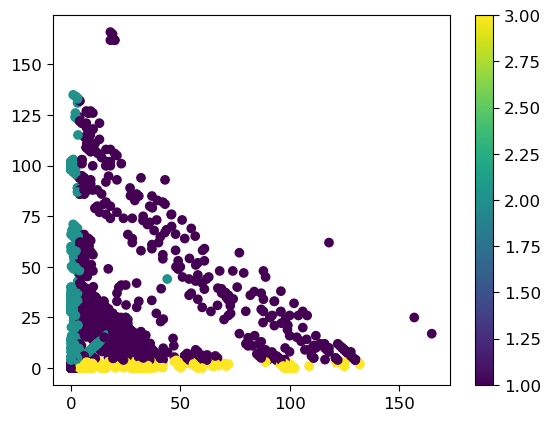

In [271]:
phase_df1 = pd.DataFrame({'Sample': hlatypes['Sample ID'].values, 'phase1': phased1, 'phase2': phased2})

plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
plt.colorbar()

In [272]:
all_haplotypes = np.append(allele1, allele2)
nameset = np.unique(all_haplotypes[all_haplotypes != 'None'])

hrcalleles = pd.concat([hrcfirstalleles, hrcsecondalleles])

predmat = np.zeros((len(nameset), obsgen.shape[1]))
for i, name in enumerate(nameset):
    predmat[i, :] = np.mean(hrcalleles.iloc[all_haplotypes == name, :], axis=0)

predmatallele1 = np.full((len(reftypes1), obsgen.shape[1]), np.nan)
predmatallele2 = np.full((len(reftypes1), obsgen.shape[1]), np.nan)

for i in range(len(reftypes1)):
    if reftypes1[i] in nameset: 
        predmatallele1[i, :] = predmat[np.where(nameset == reftypes1[i])[0][0], :]
    if reftypes2[i] in nameset: 
        predmatallele2[i, :] = predmat[np.where(nameset == reftypes2[i])[0][0], :]

dist11 = np.sum(np.abs(hrcfirstalleles - predmatallele1) > 0.9, axis=1)
dist12 = np.sum(np.abs(hrcfirstalleles - predmatallele2) > 0.9, axis=1)
dist21 = np.sum(np.abs(hrcsecondalleles - predmatallele1) > 0.9, axis=1)
dist22 = np.sum(np.abs(hrcsecondalleles - predmatallele2) > 0.9, axis=1)

phase1b = dist11 + dist22
phase2b = dist12 + dist21

d11 = dist11
d21 = dist21
d12 = dist12
d22 = dist22

phased1b = (
    (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b < phase2b)) |
    ((reftypes1 != 'nan') & (reftypes2 != 'nan') & (reftypes1 == reftypes2)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d12 - d22 > 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d21 - d11 > 2))
)

phased2b = (
    (~np.isnan(phase1b) & ~np.isnan(phase2b) & (phase1b > phase2b)) |
    (np.isnan(d21) & ~np.isnan(d12) & (d22 - d12 > 2)) |
    (np.isnan(d12) & ~np.isnan(d21) & (d11 - d21 > 2))
)

update = ~phased1 & ~phased2
phased1[update] = phased1b[update]
phased2[update] = phased2b[update]

In [273]:
phase_df2 = pd.DataFrame({'Sample': hlatypes['Sample ID'].values, 'phase1': phased1, 'phase2': phased2})
phase_df2['allele1'] = 'N/A'
phase_df2['allele2'] = 'N/A'

for i in range(len(phase_df2)):
    p1, p2 = phase_df2.loc[i, ['phase1', 'phase2']]
    if (not p1) and p2:
        phase_df2.loc[i, 'allele1'] = reftypes2[i]
        phase_df2.loc[i, 'allele2'] = reftypes1[i]
    elif (not p2) and p1:
        phase_df2.loc[i, 'allele1'] = reftypes1[i]
        phase_df2.loc[i, 'allele2'] = reftypes2[i]
    else:
        phase_df2.loc[i, 'allele1'] = 'N/A'
        phase_df2.loc[i, 'allele2'] = 'N/A'

quilt_phase = pd.read_csv('/well/band/users/rbx225/recyclable_files/hla/1KG_phased_DRB1.tsv', sep = '\t')

phased_indices = phase_df2.index[(phase_df2['phase1'] | phase_df2['phase2'])]
print('Number of unphased samples:', len(phase_df2) - len(phased_indices))

df1 = phase_df2.loc[phased_indices,:]
df2 = quilt_phase.loc[phased_indices,:]

matched_haps = df1['phase1'] == df2['phase1_final']
percet_matched_haps = (matched_haps.sum() / len(df1)) * 100
print(f'Percentage agreed with QUILT phasing for {gene}: ', percet_matched_haps, '%')

unphased_indices = phase_df2.index[~(phase_df2['phase1'] | phase_df2['phase2'])]
unphased_df = pd.DataFrame({
    'phase1': oldphase1[unphased_indices],
    'phase2': oldphase2[unphased_indices],
    'type1': reftypes1[unphased_indices],
    'type2': reftypes2[unphased_indices]
})
unphased_df

Number of unphased samples: 35
Percentage agreed with QUILT phasing for DRB1:  96.64429530201343 %


,phase1,phase2,type1,type2
0,14.000000,14.000000,04:01,04:04
1,2.000000,2.000000,13:12,14:54
2,0.000000,0.000000,03:01,03:02
3,1.000000,1.000000,13:03,14:54
4,22.333333,15.666667,08:03,07:01
5,0.000000,0.000000,11:01,13:03
6,0.025641,0.025641,15:01,15:03
7,0.000000,0.000000,01:01,01:03
8,2.775641,2.775641,15:01,15:02
9,1.200000,0.800000,11:02,13:04


* Of all 2568 samples, 34 are unphased with this approach
* We are not really able to test this phasing utility with 1000G trios because only 8 of them are phasable, of which we phased 7 of them correctly.
* This new implementation has 96.8% agreed phasing from the QUILT implementation, in DRB1.

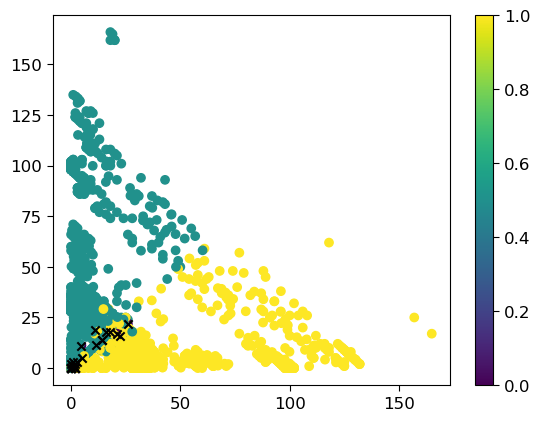

In [274]:
plt.scatter(oldphase1, oldphase2, c=1 + phased1.astype(int) + 2 * phased2.astype(int))
indices = phase_df2.index[phase_df2['allele1'] == 'N/A']
plt.scatter(oldphase1[indices], oldphase2[indices], c = 'black', marker = 'x')
plt.colorbar()

In [23]:
unphased_samples_to_remove = hlatypes.loc[indices, 'Sample ID'].tolist()
samples_to_remove = samples_to_remove + unphased_samples_to_remove

In [280]:
# QUILT phasing is in the order of maternal-paternal

trios = pd.read_csv('/well/band/users/rbx225/recyclable_files/ref_panels/oneKG/integrated_call_samples_v3.20200731.ALL.ped', sep = '\t')
trios = trios[trios['Individual ID'].isin(retained_samples)]
trios = trios[(trios['Paternal ID'].isin(retained_samples)) | (trios['Maternal ID'].isin(retained_samples))]
trios = trios[['Individual ID', 'Paternal ID', 'Maternal ID']]

trios['allele1'] = 'N/A'
trios['allele2'] = 'N/A'
undetermined_trios = []

def phase(r, gene, hlatypes = hlatypes):
    kid = r['Individual ID']
    pat = r['Paternal ID']
    mat = r['Maternal ID']
    
    lst_kid = hlatypes[hlatypes['Sample ID'] == kid][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values[0]
    set_kid = set(lst_kid)
    
    pattypes = hlatypes[hlatypes['Sample ID'] == pat][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values
    if len(pattypes) != 0:
        lst_pat = pattypes[0]
        set_pat = set(lst_pat)
    else:
        set_pat = {None}
        pattypes = None
    mattypes = hlatypes[hlatypes['Sample ID'] == mat][['HLA-' + gene + ' 1', 'HLA-' + gene + ' 2']].values
    if len(mattypes) != 0:
        lst_mat = mattypes[0]
        set_mat = set(lst_mat)
    else:
        set_mat = {None}
        mattypes = None
    
    if np.nan in set_kid:
        if len(set_kid) == 1:
            undetermined_trios.append(kid)
        elif len(set_kid) == 2:
            set_kid.discard(np.nan)
            kidtype = list(set_kid)[0]
            if np.nan not in (set_pat.union(set_mat)):
                if (kidtype in set_pat) and (kidtype not in set_mat):
                    r['allele1'] = kidtype
                elif (kidtype in set_mat) and (kidtype not in set_pat):
                    r['allele2'] = kidtype
                else:
                    pass
            else:
                if (np.nan not in set_mat) and (kidtype not in set_mat):
                    r['allele1'] = kidtype
                elif (np.nan not in set_pat) and (kidtype not in set_pat):
                    r['allele2'] = kidtype
                else:
                    undetermined_trios.append(kid)
    else:
        if len(set_kid) == 1:
            r['allele1'] = lst_kid[0]
            r['allele2'] = lst_kid[0]
        else:
            if (lst_kid[0] in set_pat) and (lst_kid[0] not in set_mat):
                if np.nan not in set_mat:
                    r['allele1'] = lst_kid[0]
                    r['allele2'] = lst_kid[1]
                else:
                    if lst_kid[1] not in set_pat:
                        r['allele1'] = lst_kid[0]
                        r['allele2'] = lst_kid[1]
                    else:
                        undetermined_trios.append(kid)
            elif (lst_kid[1] in set_pat) and (lst_kid[1] not in set_mat):
                if np.nan not in set_mat:
                    r['allele1'] = lst_kid[1]
                    r['allele2'] = lst_kid[0]
                else:
                    if lst_kid[0] not in set_pat:
                        r['allele1'] = lst_kid[1]
                        r['allele2'] = lst_kid[0]
                    else:
                        undetermined_trios.append(kid)  
            elif (lst_kid[0] in set_mat) and (lst_kid[0] not in set_pat):
                if np.nan not in set_pat:
                    r['allele1'] = lst_kid[1]
                    r['allele2'] = lst_kid[0]
                else:
                    if lst_kid[1] not in set_mat:
                        r['allele1'] = lst_kid[1]
                        r['allele2'] = lst_kid[0]
                    else:
                        undetermined_trios.append(kid)  
            elif (lst_kid[1] in set_mat) and (lst_kid[1] not in set_pat):
                if np.nan not in set_pat:
                    r['allele1'] = lst_kid[0]
                    r['allele2'] = lst_kid[1]
                else:
                    if lst_kid[0] not in set_mat:
                        r['allele1'] = lst_kid[0]
                        r['allele2'] = lst_kid[1]
                    else:
                        undetermined_trios.append(kid)  
    return r

trios = trios.apply(func = phase, args = (gene, hlatypes), axis = 1)

kgp_samples_idx = hlatypes.index[hlatypes['Sample ID'].isin(trios['Individual ID'])].to_numpy()
kgp_samples_phase = phased1[kgp_samples_idx]

phased_res = pd.DataFrame({'Sample ID': trios['Individual ID'].tolist(), 'allele1': reftypes1[kgp_samples_idx], 'allele2': reftypes2[kgp_samples_idx]})

for i in range(len(phased_res)):
    if kgp_samples_phase[i] == False:
        tmp = phased_res.iloc[i, 1]
        phased_res.iloc[i, 1] = phased_res.iloc[i, 2]
        phased_res.iloc[i, 2] = tmp

res = pd.merge(phased_res, trios[['Individual ID', 'allele1', 'allele2']], left_on = 'Sample ID', right_on = 'Individual ID', suffixes = ('_pred', '_true'))
res = res.drop(columns = 'Individual ID')
res

,Sample ID,allele1_pred,allele2_pred,allele1_true,allele2_true
0,HG00702,14:54,09:01,14:54,09:01
1,HG00733,11:04,03:01,11:04,03:01
2,HG02024,12:02,12:02,12:02,12:02
3,NA12878,03:01,01:01,03:01,01:01
4,NA19240,12:01,16:02,12:01,16:02
5,NA19675,07:01,03:01,07:01,03:01
6,NA19685,01:02,14:06,01:02,14:06
7,NA20318,15:03,11:02,11:02,15:03


In [ ]:
# RETAIN THIS!
# gamcc_hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
# gamcc_hla = gamcc_hla[['SampleID', 'Locus', 'Included Alleles']]
# for s in gamcc_hla['SampleID'].unique():
#     tmps = gamcc_hla[gamcc_hla['SampleID'] == s]
#     for l in HLA_GENES:
#         tmpl = tmps[tmps['Locus'] == l]
#         repeat = 2 - tmpl.shape[0]
#         if repeat == 2:
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, np.nan]
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, np.nan]
#         if repeat == 1:
#             gamcc_hla.loc[len(gamcc_hla)] = [s, l, tmpl.iloc[0,2]]
                
# gamcc_hla = gamcc_hla[gamcc_hla['Locus'] == gene]
# gamcc_hla = gamcc_hla[['SampleID', 'Included Alleles']]

# gamcc_hla = pd.merge(gamcc_hla[::2], gamcc_hla[1::2], on = 'SampleID')
# gamcc_hla.columns = ['Sample ID', 'HLA-DRB1 1', 'HLA-DRB1 2']
# gamcc_hla

# x = gamcc_hla.iloc[0, 1]
# indices = []
# db_alleles = db.index.to_numpy()

# for a in x.split('/'):
#     old_a = a
#     while (gene + '*' + a) not in db.index and ':' in a:
#         a = a.rsplit(':', 1)[0]
#     if ':' in a:
#         indices.append(np.where(db_alleles == gene + '*' + a)[0][0])

# x = db.iloc[np.array(indices), :]